In [1]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class LudoEnv(gym.Env):
    def __init__(self):
        super(LudoEnv, self).__init__()
        self.num_pieces = 4
        self.track_length = 57
        self.action_space = spaces.Discrete(self.num_pieces)
        self.observation_space = spaces.Box(low=0, high=self.track_length, shape=(8,), dtype=np.int32)
        self.reset()

    def reset(self):
        self.positions = {
            1: np.zeros(self.num_pieces, dtype=np.int32),
            2: np.zeros(self.num_pieces, dtype=np.int32)
        }
        self.done = False
        self.current_player = 1
        return self._get_obs()

    def _get_obs(self):
        current = self.positions[self.current_player]
        opponent = self.positions[3 - self.current_player]
        return np.concatenate([current, opponent])

    def step(self, action):
        if self.done:
            return self._get_obs(), 0, True, False, {}

        dice = np.random.randint(1, 7)
        reward = 0
        player = self.current_player

        if self.positions[player][action] < self.track_length:
            self.positions[player][action] += dice
            if self.positions[player][action] >= self.track_length:
                self.positions[player][action] = self.track_length
                reward = 50
            else:
                reward = 1

        if np.all(self.positions[player] >= self.track_length):
            self.done = True
            reward = 100

        self.current_player = 3 - self.current_player
        return self._get_obs(), reward, self.done, False, {}


In [3]:
class DQN(nn.Module):
    # Initializes the neural network layers.
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256) # First fully connected layer that maps state to 256 hidden units
        self.fc2 = nn.Linear(256, 256) # Second fully connected layer that processes the 256 hidden units
        self.fc3 = nn.Linear(256, action_size) # Output layer that maps to the Q-values of all possible actions

    #  Defines the forward pass of the network.
    def forward(self, state):
        x = torch.relu(self.fc1(state)) # Apply ReLU activation to the output of the first layer
        x = torch.relu(self.fc2(x)) # Apply ReLU activation to the output of the second layer
        return self.fc3(x) # Output Q-values from the final layer

In [4]:
class ReplayBuffer:
    # Initialize the buffer with a given capacity
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)# Using deque to store experiences, with a maximum length (capacity)
     # Add a new experience to the buffer (state, action, reward, next_state, done)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) # Append the experience to the buffer

    # Sample a batch of experiences from the buffer
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size) # Randomly select a batch of experiences
        return zip(*transitions) # Return the experiences separated into different components

    # Return the current size of the buffer
    def __len__(self):
        return len(self.buffer)


In [5]:
!pip install numpy==1.24.4

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require 


--- Evaluation Results ---
Player 1
  Cumulative Reward: 22238
  Mean Last 10: 47.40
  StdDev Last 10: 44.78
  Convergence Time: Not Converged
Player 2
  Cumulative Reward: 21367
  Mean Last 10: 49.20
  StdDev Last 10: 43.65
  Convergence Time: Not Converged


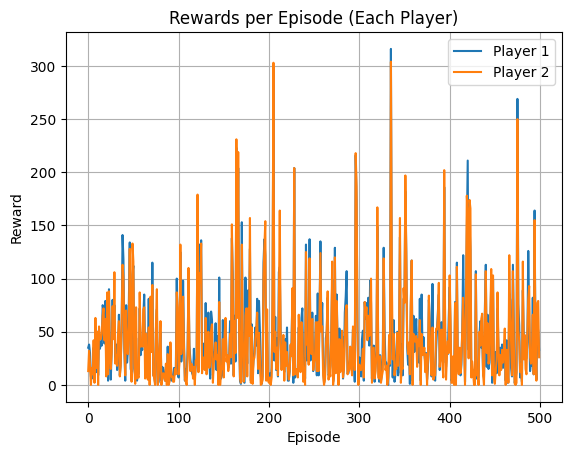

In [6]:
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# --- تعريف Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

# --- تعريف شبكة DQN ---
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# --- تعريف بيئة Ludo ---
class LudoEnv(gym.Env):
    def __init__(self):
        super(LudoEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=1, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)
        self.state = None

    def reset(self):
        self.state = np.random.rand(8).astype(np.float32)
        return self.state

    def step(self, action):
        next_state = np.random.rand(8).astype(np.float32)
        reward = np.random.randint(0, 10)
        done = np.random.rand() > 0.95
        return next_state, reward, done, {}

# --- تسجيل البيئة ---
from gym.envs.registration import register
register(id='Ludo-v0', entry_point='__main__:LudoEnv')

# --- إعداد البيئة ---
env = gym.make('Ludo-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- إعداد اللاعبين ---
players = {
    1: {
        "policy": DQN(8, 4).to(device),
        "target": DQN(8, 4).to(device),
        "optimizer": None,
        "buffer": ReplayBuffer(10000),
        "rewards": [],
        "converged": False,
        "convergence_ep": -1
    },
    2: {
        "policy": DQN(8, 4).to(device),
        "target": DQN(8, 4).to(device),
        "optimizer": None,
        "buffer": ReplayBuffer(10000),
        "rewards": [],
        "converged": False,
        "convergence_ep": -1
    }
}

for p in players:
    players[p]["target"].load_state_dict(players[p]["policy"].state_dict())
    players[p]["target"].eval()
    players[p]["optimizer"] = optim.Adam(players[p]["policy"].parameters(), lr=0.001)

# --- إعدادات التدريب ---
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500
target_update_freq = 10
batch_size = 64
episodes = 500

# --- حلقة التدريب ---
for episode in range(episodes):
    state = env.reset()
    state = torch.FloatTensor(state).to(device)
    done = False
    rewards = {1: 0, 2: 0}
    current_player = 1

    while not done:
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
        if random.random() < epsilon:
            action = random.randint(0, 3)
        else:
            with torch.no_grad():
                q_values = players[current_player]["policy"](state)
                action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)
        next_state_tensor = torch.FloatTensor(next_state).to(device)

        players[current_player]["buffer"].push(state.cpu().numpy(), action, reward, next_state, done)
        rewards[current_player] += reward
        state = next_state_tensor
        current_player = 3 - current_player

        if len(players[1]["buffer"]) > batch_size and len(players[2]["buffer"]) > batch_size:
            for p in [1, 2]:
                states, actions, rewards_b, next_states, dones = players[p]["buffer"].sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_b = torch.FloatTensor(rewards_b).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                q_values = players[p]["policy"](states).gather(1, actions)
                max_next_q = players[p]["target"](next_states).max(1)[0].detach()
                expected_q = rewards_b + gamma * max_next_q * (1 - dones)

                loss = nn.MSELoss()(q_values.squeeze(), expected_q)
                players[p]["optimizer"].zero_grad()
                loss.backward()
                players[p]["optimizer"].step()

    for p in [1, 2]:
        players[p]["rewards"].append(rewards[p])
        if not players[p]["converged"] and episode > 20:
            recent = players[p]["rewards"][-10:]
            if np.std(recent) < 5.0 and np.mean(recent) > 80:
                players[p]["converged"] = True
                players[p]["convergence_ep"] = episode

    if episode % target_update_freq == 0:
        for p in players:
            players[p]["target"].load_state_dict(players[p]["policy"].state_dict())

# --- التقييم ---
print("\n--- Evaluation Results ---")
for p in players:
    print(f"Player {p}")
    print(f"  Cumulative Reward: {sum(players[p]['rewards'])}")
    print(f"  Mean Last 10: {np.mean(players[p]['rewards'][-10:]):.2f}")
    print(f"  StdDev Last 10: {np.std(players[p]['rewards'][-10:]):.2f}")
    print(f"  Convergence Time: {players[p]['convergence_ep'] if players[p]['convergence_ep'] != -1 else 'Not Converged'}")

# --- رسم الأداء ---
plt.plot(players[1]["rewards"], label="Player 1")
plt.plot(players[2]["rewards"], label="Player 2")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Rewards per Episode (Each Player)")
plt.legend()
plt.grid(True)
plt.show()
